In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns
import json

from apelfei.contrast import ContrastResults, collect_all_data_setup_configs, estimate_stellar_flux
from apelfei.utils.data_handling import open_fits, save_as_fits, load_adi_data
from apelfei.utils.aperture_photometry import flux_ratio2mag, mag2flux_ratio, AperturePhotometryMode

Found installation of parallel_sort and use it.


## This code is about

This compute the throughput values displaied in the appendix plot 3.

## Load all config files and residuals

In [2]:
experiment_root = "../../../70_results/part1/detection_limits/Beta_Pic_non_stacked/"

In [3]:
all_configs = collect_all_data_setup_configs(os.path.join(experiment_root, 
                                                          "configs_cmap"))

In [4]:
# collect all the residual files with configs
all_method_results = dict()
algorithm_config_dir = os.path.join(experiment_root, "configs_algo")

for tmp_file in sorted(os.listdir(algorithm_config_dir)):
    # ignore system files
    if tmp_file.startswith("."):
        continue

    tmp_algo_config_file = os.path.join(algorithm_config_dir, tmp_file)
    with open(tmp_algo_config_file) as json_file:
        tmp_algorithm_config = json.load(json_file)
    
    tmp_algo = tmp_algorithm_config['method_name']
    print("Found algorithm config file for method " + str(tmp_algo))
    print("Collecting residuals...")
    
    # Loop over all fake planet experiments
    tmp_all_results = []
    for tmp_config in all_configs:
        tmp_id, tmp_cmap_config_file = tmp_config
        
        tmp_residual_file = os.path.join(experiment_root, 
                                         "pca_residuals",
                                         tmp_algo +"_ID_" + tmp_id + ".fits")
                  
        # save residual and config file paths
        tmp_all_results.append((tmp_cmap_config_file, tmp_residual_file))
        
    print("[DONE] - Found " + str(len(tmp_all_results)) + " residuals.")
    all_method_results[tmp_algo] = tmp_all_results

Found algorithm config file for method pca_005
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_010
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_020
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_030
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_040
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_050
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_075
[DONE] - Found 2017 residuals.
Found algorithm config file for method pca_100
[DONE] - Found 2017 residuals.


In [5]:
all_method_results["pca_005"][0]

('../../../70_results/part1/detection_limits/Beta_Pic_non_stacked/configs_cmap/exp_ID_0000.json',
 '../../../70_results/part1/detection_limits/Beta_Pic_non_stacked/pca_residuals/pca_005_ID_0000.fits')

## Read the data for the PSF template data¶

In [6]:
dataset_json_file = os.path.join(experiment_root, "dataset.json")
config_dir = os.path.join(experiment_root, "configs_cmap")
algo_config_root = os.path.join(experiment_root, "configs_algo")
residual_result_dir = os.path.join(experiment_root, "pca_residuals")

with open(dataset_json_file) as json_file:
    tmp_dataset_config = json.load(json_file)

In [7]:
tmp_dataset_config

{'file_path': '../../../30_data/BetaPic/betapic_naco_lp_full.hdf5',
 'stack_key': 'full_no_planet',
 'psf_template_key': 'flux',
 'parang_key': 'header_full/PARANG',
 'dit_psf_template': 0.02019,
 'dit_science': 0.2,
 'crop_science': 55,
 'crop_template': 82}

In [8]:
# we need the psf template for contrast calculation
science_data, _, raw_psf_template_data = load_adi_data(tmp_dataset_config["file_path"],
                                                       data_tag=tmp_dataset_config["stack_key"],
                                                       psf_template_tag=tmp_dataset_config["psf_template_key"],
                                                       para_tag=tmp_dataset_config["parang_key"])

dit_psf_template = tmp_dataset_config["dit_psf_template"]
dit_science = tmp_dataset_config["dit_science"]

In [9]:
# Cut the data to the innermost 8 lambda / D
crop_science = tmp_dataset_config["crop_science"]
crop_template = tmp_dataset_config["crop_template"]

science_data = science_data[:,
                            crop_science:-crop_science,
                            crop_science:-crop_science]

psf_template_data = raw_psf_template_data[crop_template:-crop_template, 
                                          crop_template:-crop_template]

test_frame = science_data[0, :, :]

## Create the Contrast Evaluator - photometry on apertures

In [10]:
photometry_mode_planet = AperturePhotometryMode("FS", search_area=0.5)
photometry_mode_noise = AperturePhotometryMode("P")

In [11]:
# 1.) Compute the stellar flux
stellar_flux = estimate_stellar_flux(
    psf_template=psf_template_data,
    dit_science=tmp_dataset_config["dit_science"],
    dit_psf_template=tmp_dataset_config["dit_psf_template"],
    photometry_mode=photometry_mode_planet,
    scaling_factor=1.)

In [12]:
contrast_results = dict()

for pca_setup, result_files in all_method_results.items():
    print(pca_setup)
    tmp_contrast_result = ContrastResults(model_results_in=result_files,
                                          stellar_flux=stellar_flux,
                                          planet_photometry_mode=photometry_mode_planet,
                                          noise_photometry_mode=photometry_mode_noise,
                                          psf_fwhm_radius=2.1)
    contrast_results[pca_setup] = tmp_contrast_result

pca_005
pca_010
pca_020
pca_030
pca_040
pca_050
pca_075
pca_100


## Plot the Throughput map for two PCA configs

In [13]:
contrast_results_1 = contrast_results["pca_030"]

throughput_results_1 = contrast_results_1.compute_throughput().T
throughput_results_1.index = flux_ratio2mag(throughput_results_1.index)
throughput_results_1.columns = (throughput_results_1.columns/4.2).astype("int")
throughput_results_1 = throughput_results_1.iloc[:17, :].iloc[::2, ::2]

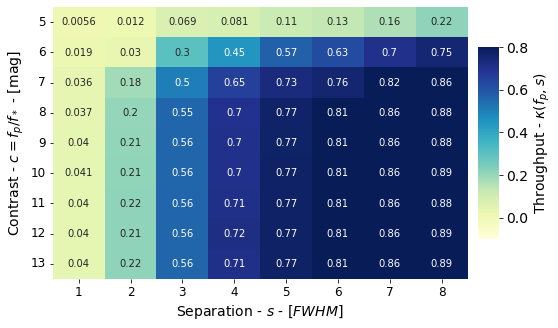

In [14]:
fig = plt.figure(constrained_layout=False, figsize=(8, 5))

gs0 = fig.add_gridspec(1, 2, width_ratios = [1, 0.05])
gs0.update(wspace=0.05)

gs1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = gs0[0], hspace=0.12)
gs2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec = gs0[1], height_ratios=[0.1, 0.8, 0.1])

# q-q Plots
throughput_ax1 = fig.add_subplot(gs1[0])
colorbar_ax = fig.add_subplot(gs2[1])

# define a function for the plot (we need the code twice)
def plot_throughput(axis_in,
                    tmp_throughput_results,
                    color_bar):
    
    c_bar_kargs = dict(orientation = "vertical",
                       label = r"Throughput - $\kappa(f_p, s)$")
    
    heat = sns.heatmap(tmp_throughput_results,
                       vmax=0, vmin=0.8, 
                       annot=True,
                       cmap="YlGnBu",
                       ax=axis_in,
                       cbar_ax=colorbar_ax,
                       cbar_kws=c_bar_kargs)
    
    ylabels = ['{:d}'.format(int(float(x.get_text()))) for x in heat.get_yticklabels()]
    _=heat.set_yticklabels(ylabels)

# Plot the first throughput map
plot_throughput(throughput_ax1, throughput_results_1,
                color_bar=False)
#throughput_ax1.set_xticklabels([])
throughput_ax1.set_ylabel("Contrast - $c = f_p / f_*$ - [mag]", size=14)
throughput_ax1.set_xlabel(None)
throughput_ax1.tick_params(axis='both', which='major', labelsize=12)


cbar = throughput_ax1.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
throughput_ax1.figure.axes[-1].yaxis.label.set_size(14)

throughput_ax1.set_ylabel(r"Contrast - $c = f_p / f_*$ - [mag]", size=14)
throughput_ax1.set_xlabel(r"Separation - $s$ - $\left[FWHM \right]$", size=14)
#throughput_ax1.set_title("Fake Planet Throughput", fontsize=16, fontweight="bold", y=1.03)

fig.patch.set_facecolor('white')
plt.savefig("./12_Throughput.pdf", bbox_inches='tight')